# O3 Air Pollution Predictive Modelling.

Imports

In [41]:
#data frame
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# machine laerning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa


from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn import preprocessing


## Time series analysis

Reading in data

In [49]:
# Loading the dataset
df = pd.read_csv('India_complete.csv', low_memory=False)

# Parse datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract useful time features
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek
df['year'] = df['datetime'].dt.year - df['datetime'].dt.year.min()

# Displaying the first few rows of the dataframe
print(df.head())

             datetime StationId                     StationName       City  \
0 2017-11-24 17:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   
1 2017-11-24 18:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   
2 2017-11-24 19:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   
3 2017-11-24 20:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   
4 2017-11-24 21:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   

            State        lat        lon  Status  PM2.5    PM10  ...   CO  \
0  Andhra Pradesh  16.494222  80.510586  Active  60.50   98.00  ...  0.1   
1  Andhra Pradesh  16.494222  80.510586  Active  65.50  111.25  ...  0.1   
2  Andhra Pradesh  16.494222  80.510586  Active  80.00  132.00  ...  0.1   
3  Andhra Pradesh  16.494222  80.510586  Active  81.50  133.25  ...  0.1   
4  Andhra Pradesh  16.494222  80.510586  Active  75.25  116.00  ...  0.1   

     SO2      O3  AQI  AQI_Bucket  hour  month  day dayofweek  year  
0  1

Descriptive Stats

In [47]:
# Summary statistics for numeric variables
def summary_stats(df):

    # print nimber of stations
    print(f"Number of unique stations: {df['StationId'].nunique()}")
    
    print("Descriptive Statistics:")
    df_desc = df.drop(['hour', 'month', 'dayofweek', 'datetime', 'lat', 'lon', 'day'], axis=1)
    print(df_desc.describe())

    print("Missing Values:")
    print(df.isnull().sum())

summary_stats(df)

Number of unique stations: 110
Descriptive Statistics:
              PM2.5          PM10            NO           NO2           NOx  \
count  1.941394e+06  1.469831e+06  2.035372e+06  2.060110e+06  2.098275e+06   
mean   8.086481e+01  1.584839e+02  2.278825e+01  3.523689e+01  4.055115e+01   
std    8.947618e+01  1.397883e+02  4.846146e+01  3.497508e+01  5.590894e+01   
min    1.000000e-02  1.000000e-02  1.000000e-02  1.000000e-02  0.000000e+00   
25%    2.816000e+01  6.400000e+01  3.050000e+00  1.310000e+01  1.135000e+01   
50%    5.259000e+01  1.162500e+02  7.150000e+00  2.479000e+01  2.286000e+01   
75%    9.774000e+01  2.040000e+02  1.858000e+01  4.548000e+01  4.570000e+01   
max    1.000000e+03  1.000000e+03  5.000000e+02  4.999900e+02  5.000000e+02   

                NH3            CO           SO2            O3           AQI  
count  1.352465e+06  2.089781e+06  1.846346e+06  1.863110e+06  2.018893e+06  
mean   2.870856e+01  1.502366e+00  1.211602e+01  3.806408e+01  1.801730e+02  

In [48]:
def o3_stats(df):
    # Print O3 statistics
    print(f"\nO3 Statistics:")
    print(f"Mean O3: {df['O3'].mean():.2f}")
    print(f"Median O3: {df['O3'].median():.2f}")
    print(f"Min O3: {df['O3'].min():.2f}")
    print(f"Max O3: {df['O3'].max():.2f}")

o3_stats(df)


O3 Statistics:
Mean O3: 38.06
Median O3: 24.75
Min O3: 0.01
Max O3: 997.00


Map visualsation

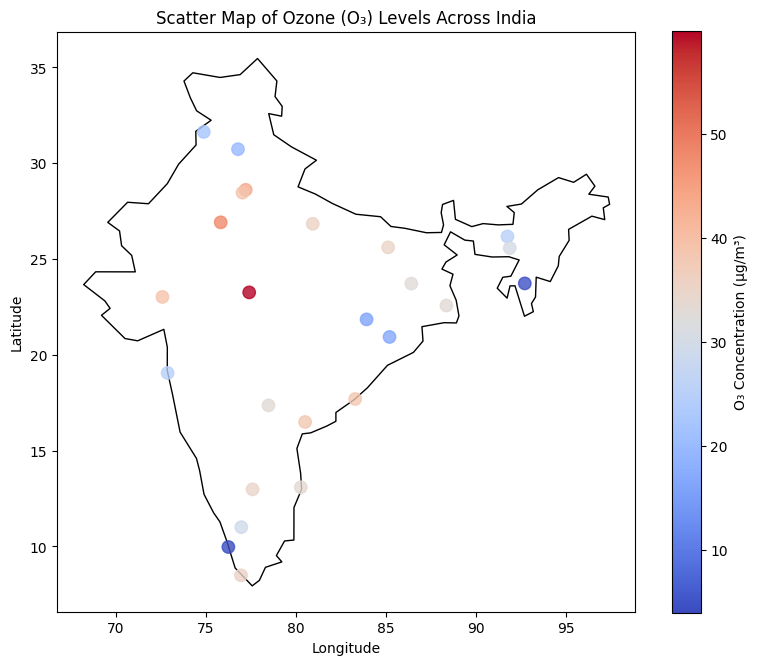

In [49]:
def map_vis(df):

    # Load Natural Earth countries (1:110m resolution)
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url)

    # Filter for India
    india = world[world["ADMIN"] == "India"]


    # grouping by city as hard to see individual points otherwise

    # groups by city and takes mean of O3 values
    df_mean = df.groupby(['City']).mean('O3').reset_index()
    # Remove rows with NaN values in or 'O3' columns
    df_clean = df_mean.dropna(subset=["O3"])

    gdf = gpd.GeoDataFrame(
        df_clean,  # remove NaNs
        geometry=gpd.points_from_xy(df_clean["lon"], df_clean["lat"]),
        crs="EPSG:4326"
    )

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(8, 10))
    india.plot(ax=ax, color="white", edgecolor="black")  # India boundary

    # Scatter plot of O3 levels
    gdf.plot(
        ax=ax,
        column="O3",        # pollutant column
        cmap="coolwarm",        # color scheme
        markersize=80,      # adjust dot size
        alpha=0.8,
        legend=True,
        legend_kwds={
        "label": "O₃ Concentration (µg/m³)",   # ← your legend label
        "shrink": 0.6                         # optional: smaller colorbar
    }
    )

    plt.title("Scatter Map of Ozone (O₃) Levels Across India")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()

map_vis(df)

Visualising time series.

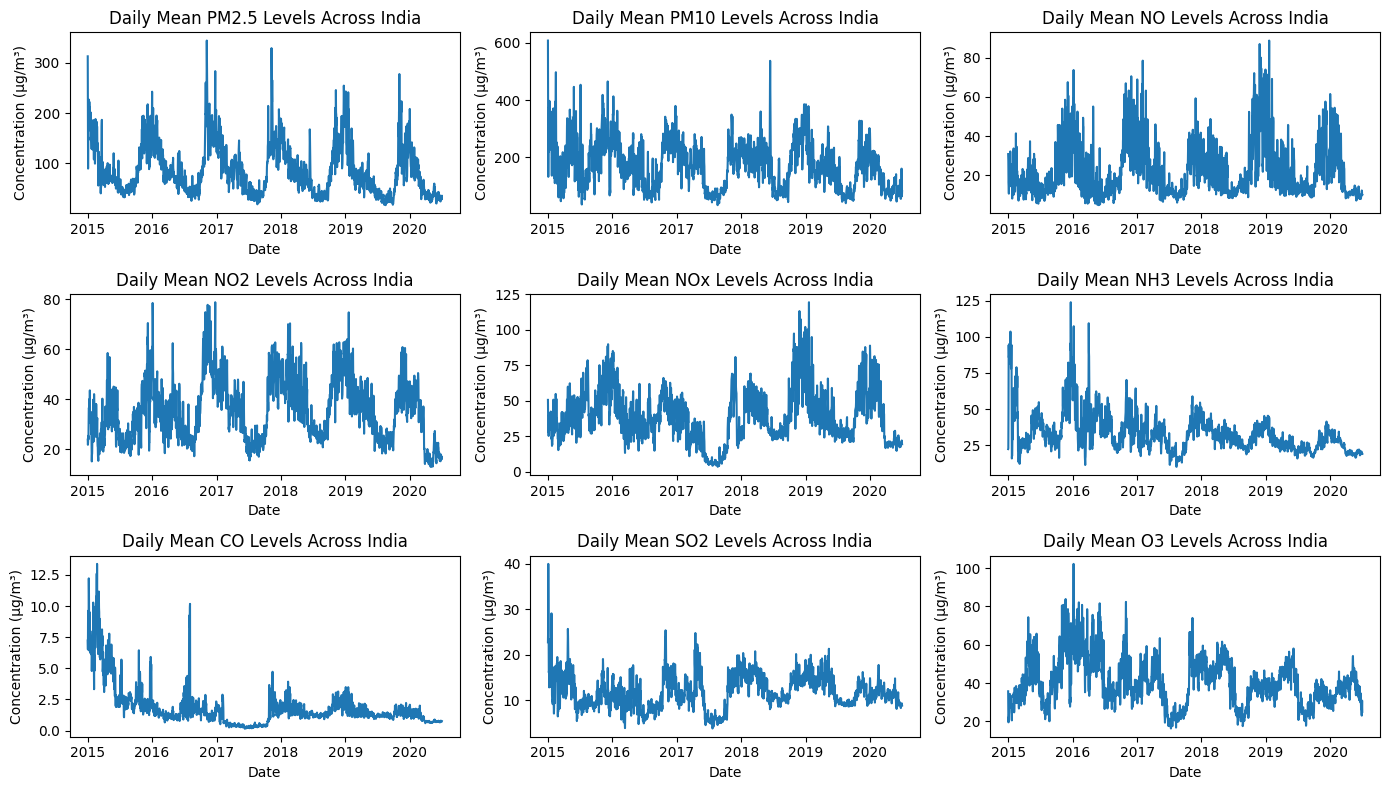

In [50]:
def ozone_time_series(df):
    
    # group by day (drop the time component)
    df_mean = (
        df.groupby(df['datetime'].dt.date)['O3']
        .mean()
        .reset_index()
    )

    # rename for clarity
    df_mean.columns = ['date', 'O3']

    # plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_mean, x='date', y='O3')
    plt.title('Daily Mean Ozone (O₃) Levels Across India')
    plt.xlabel('Date')
    plt.ylabel('O₃ Concentration (µg/m³)')
    plt.tight_layout()
    plt.show()


def all_pollutatants_time_series(df):

    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    monthly_mean = (
    df.groupby(pd.Grouper(key='datetime', freq='D'))[pollutants]
      .mean()
      .reset_index()
    )

    # plot on different graphs for clarity

    plt.figure(figsize=(14, 8))
    for i, pollutant in enumerate(pollutants, 1):
        plt.subplot(3, 3, i)
        sns.lineplot(data=monthly_mean, x='datetime', y=pollutant)
        plt.title(f'Daily Mean {pollutant} Levels Across India')
        plt.xlabel('Date')
        plt.ylabel('Concentration (µg/m³)')
        plt.tight_layout()
    plt.show()
    

#ozone_time_series(df)
all_pollutatants_time_series(df)

Random station ozone time series

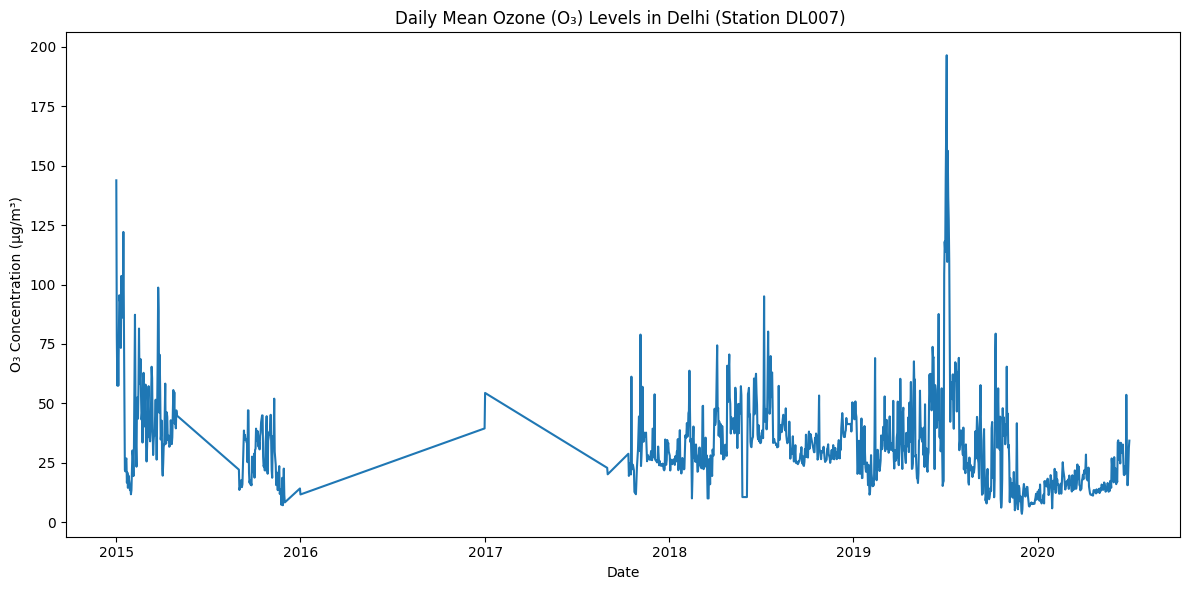

In [51]:

def random_station_ozone_time_series(df):

    # select a random city
    random_station = df['StationId'].sample(n=1).values[0]

    df_station = df[df['StationId'] == random_station]

    # group by day (drop the time component)
    df_mean = (
        df_station.groupby(df_station['datetime'].dt.date)['O3']
        .mean()
        .reset_index()
    )

    # rename for clarity
    df_mean.columns = ['date', 'O3']

    # plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_mean, x='date', y='O3')
    plt.title(f'Daily Mean Ozone (O₃) Levels in {df_station["City"].values[0]} (Station {random_station}) ')
    plt.xlabel('Date')
    plt.ylabel('O₃ Concentration (µg/m³)')
    plt.tight_layout()
    plt.show()

# can return a city with no ozone data so may need to rerun to find one that does
random_station_ozone_time_series(df)

Seasonal Trends

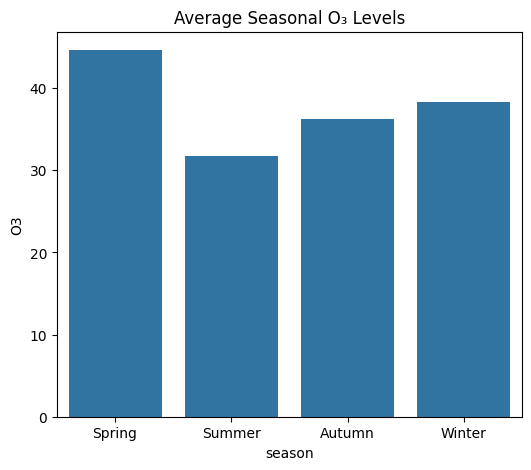

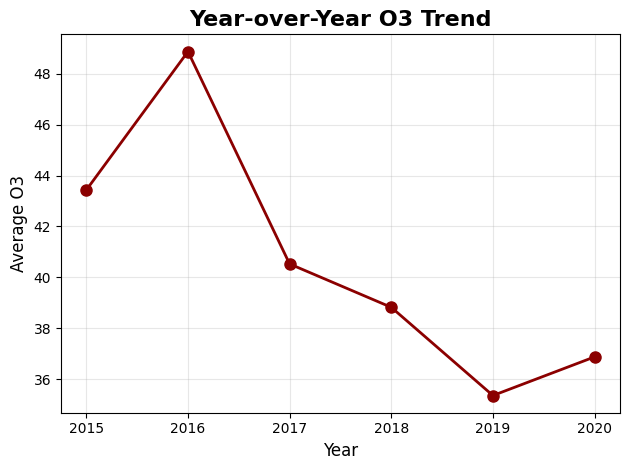

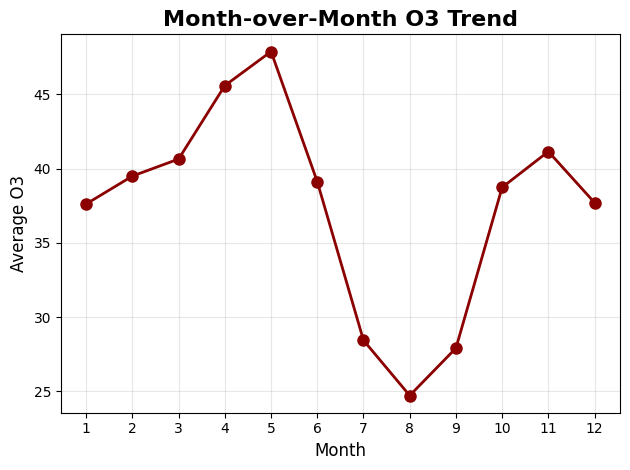

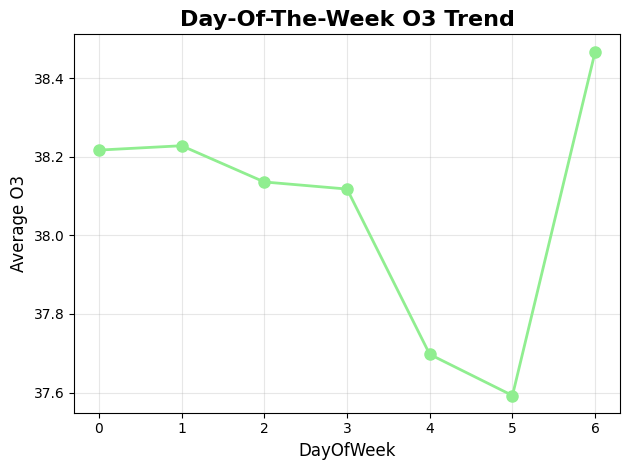

In [52]:
def yearly_fig(df):
    # Extract year from datetime
    # copy to not impact original df
    df_copy = df.copy()
    df_copy['Year'] = df_copy['datetime'].dt.year
    # # Year-over-Year O3 Trend
    yearly_O3 = df_copy.groupby('Year')['O3'].mean().reset_index()

    #print("\nYearly O3 Summary:")
    #print(yearly_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(yearly_O3['Year'], yearly_O3['O3'], marker='o', linewidth=2, 
             markersize=8, color='darkred')
    plt.title('Year-over-Year O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(yearly_O3['Year'])
    plt.tight_layout()
    plt.show()

def monthly_fig(df):
    # Month-over-Month O3 Trend
    monthly_O3 = df.groupby('month')['O3'].mean().reset_index()

    #print("\nMonthly O3 Summary:")
    #print(monthly_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(monthly_O3['month'], monthly_O3['O3'], marker='o', linewidth=2, 
            markersize=8, color='darkred')
    plt.title('Month-over-Month O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(monthly_O3['month'])
    plt.tight_layout()
    plt.show()

def day_of_week_fig(df):
    # Day of the week O3 Trend
    day_of_week_O3 = df.groupby('dayofweek')['O3'].mean().reset_index()

    #print("\nDaily O3 Summary:")
    #print(day_of_week_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(day_of_week_O3['dayofweek'], day_of_week_O3['O3'], marker='o', linewidth=2, 
            markersize=8, color='lightgreen')
    plt.title('Day-Of-The-Week O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('DayOfWeek', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(day_of_week_O3['dayofweek'])
    plt.tight_layout()
    plt.show()

def seasonal_trends(df):

    df_copy = df.copy()
    df_copy['weekday_name'] = df_copy['datetime'].dt.day_name()

    # Visualization
    plt.figure(figsize=(6,5))
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'

    df_copy['season'] = df_copy['month'].apply(get_season)

    seasonal_summary = df_copy.groupby('season')['O3'].mean().reset_index()
    sns.barplot(x='season', y='O3', data=seasonal_summary, order=['Spring', 'Summer', 'Autumn', 'Winter'])
    plt.title('Average Seasonal O₃ Levels')
    plt.show()

seasonal_trends(df)
yearly_fig(df)
monthly_fig(df)
day_of_week_fig(df)


Histograms

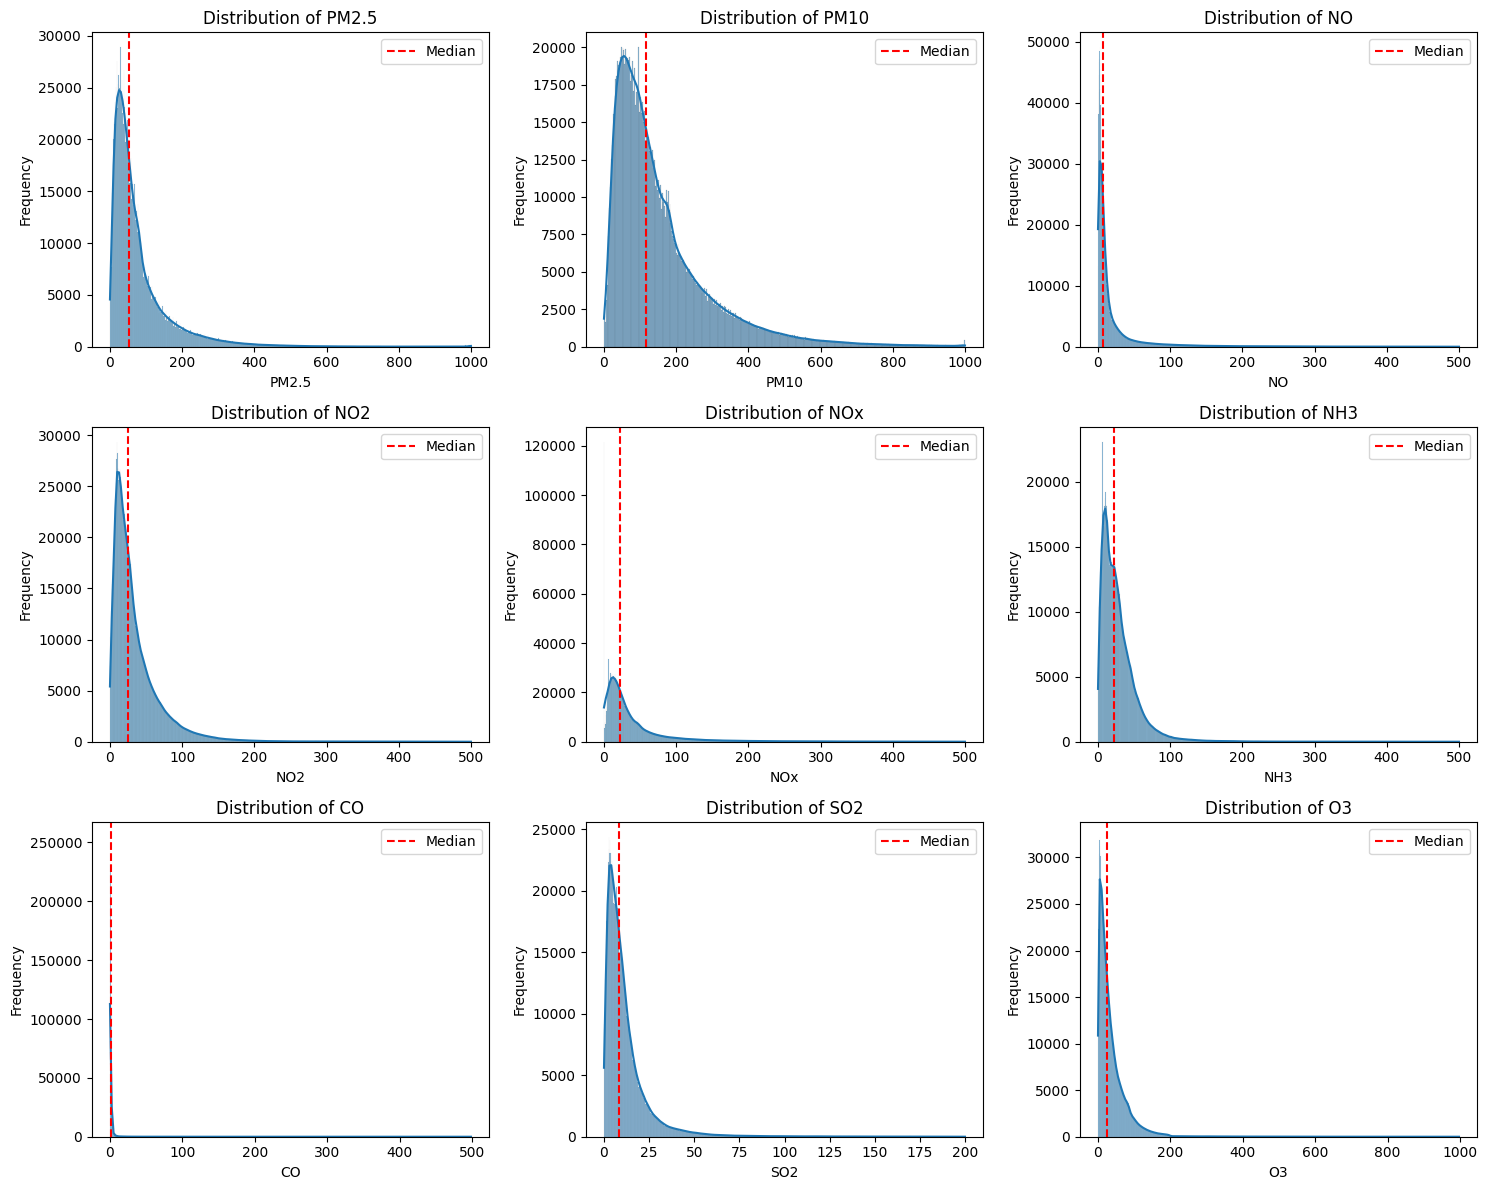

In [53]:
def histograms(df):
    numeric_features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    # Create subplots for all histograms
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()  # Make indexing easier

    for i, col in enumerate(numeric_features):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].axvline(df[col].median(), color='r', linestyle='--', label='Median'),
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()


    plt.tight_layout()
    plt.show()

histograms(df)

Correlation matrix


Correlation with O3:
AQI          0.132111
hour         0.103756
SO2          0.098339
NH3          0.084150
lat          0.083183
NO2          0.060923
PM2.5        0.057122
PM10         0.002009
dayofweek   -0.001492
day         -0.007836
Name: O3, dtype: float64


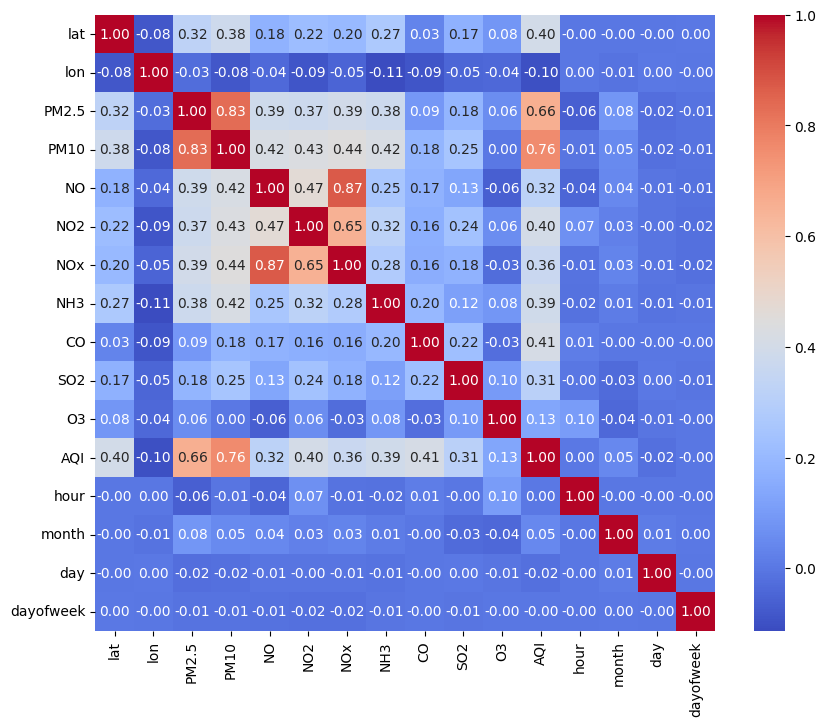

In [54]:
def correlation_matrix(df):

    # Correlation matrix for pollutants.
    df_corr = df.drop(['AQI_Bucket', 'City', 'datetime', 'StationId', 'StationName', 'Status', 'State'], axis=1)
    corr_matrix = df_corr.corr()

    # Show strong correlations with 03
    if 'O3' in corr_matrix.columns:
        O3_corr = corr_matrix['O3'].sort_values(ascending=False)
        print("\nCorrelation with O3:")
        print(O3_corr[1:11])

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

correlation_matrix(df)

Covariance Matrix

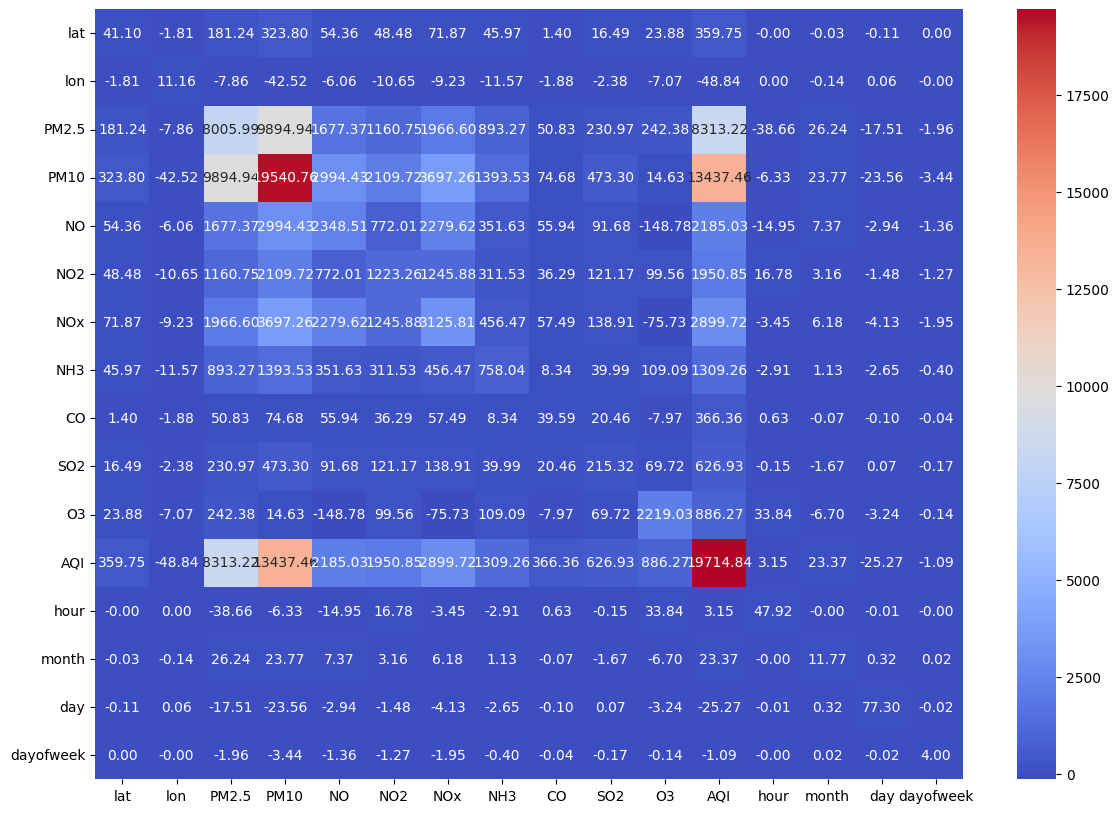

In [55]:
def cov_matrix(df):

    # Correlation matrix for pollutants.
    df_cov = df.drop(['AQI_Bucket', 'City', 'datetime', 'StationId', 'StationName', 'Status', 'State'], axis=1)
    cov_matrix = df_cov.cov()

    plt.figure(figsize=(14, 10))
    sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap='coolwarm')

cov_matrix(df)

Distribution of AQI

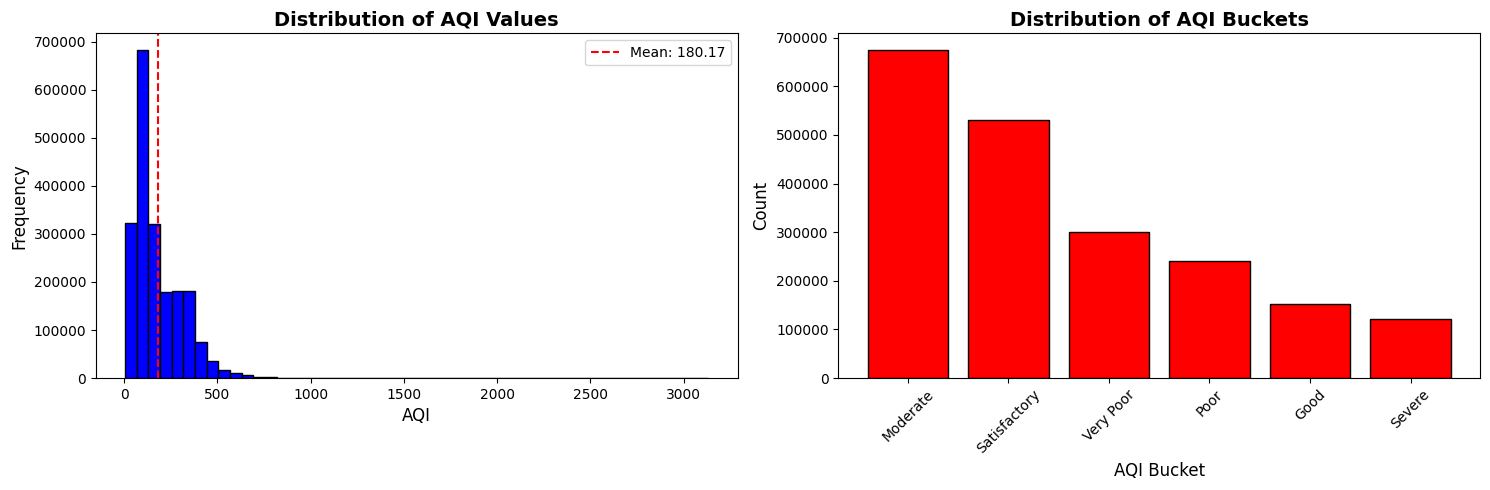

In [56]:
def aqi_plots(df):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # 03 distribution
    axes[0].hist(df['AQI'].dropna(), bins=50, color='blue', edgecolor='black')
    axes[0].set_title('Distribution of AQI Values', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('AQI', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].axvline(df['AQI'].mean(), color='red', linestyle='--', label=f'Mean: {df["AQI"].mean():.2f}')
    axes[0].legend()

    # # AQI Bucket distribution
    aqi_bucket_counts = df['AQI_Bucket'].value_counts()
    axes[1].bar(aqi_bucket_counts.index, aqi_bucket_counts.values, color='red', edgecolor='black')
    axes[1].set_title('Distribution of AQI Buckets', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('AQI Bucket', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

aqi_plots(df)

Top 50 Worst days for O3 pollution all in same place.

In [57]:
def top_O3_days(df):

    df_copy = df.copy()
    df_copy['Year'] = df_copy['datetime'].dt.year
    # Get top 50 days with Highest O3
    top_O3_days = df_copy.nlargest(50, 'O3')[['datetime', 'StationName','O3']]

    print("=" * 50)
    print("Top 50 days with Highest O3")
    print("=" * 50)
    print(top_O3_days.to_string(index=False))

top_O3_days(df)

Top 50 days with Highest O3
           datetime                StationName     O3
2019-11-03 14:00:00 Punjabi Bagh, Delhi - DPCC 997.00
2018-06-13 05:00:00 Punjabi Bagh, Delhi - DPCC 996.00
2019-11-03 07:00:00 Punjabi Bagh, Delhi - DPCC 996.00
2019-01-20 00:00:00 Punjabi Bagh, Delhi - DPCC 992.00
2017-11-08 07:00:00 Punjabi Bagh, Delhi - DPCC 989.00
2016-01-04 22:00:00 Punjabi Bagh, Delhi - DPCC 988.17
2015-11-20 12:00:00 Punjabi Bagh, Delhi - DPCC 984.33
2016-01-07 09:00:00 Punjabi Bagh, Delhi - DPCC 982.00
2019-11-03 08:00:00 Punjabi Bagh, Delhi - DPCC 982.00
2017-11-08 09:00:00 Punjabi Bagh, Delhi - DPCC 980.00
2017-11-09 09:00:00 Punjabi Bagh, Delhi - DPCC 977.00
2020-01-01 23:00:00 Punjabi Bagh, Delhi - DPCC 975.00
2016-11-02 09:00:00 Punjabi Bagh, Delhi - DPCC 974.50
2017-11-12 09:00:00 Punjabi Bagh, Delhi - DPCC 974.00
2018-06-12 15:00:00 Punjabi Bagh, Delhi - DPCC 974.00
2017-11-10 10:00:00 Punjabi Bagh, Delhi - DPCC 973.00
2017-12-11 03:00:00 Punjabi Bagh, Delhi - DPCC 973.00


Average Pollutant per stations.

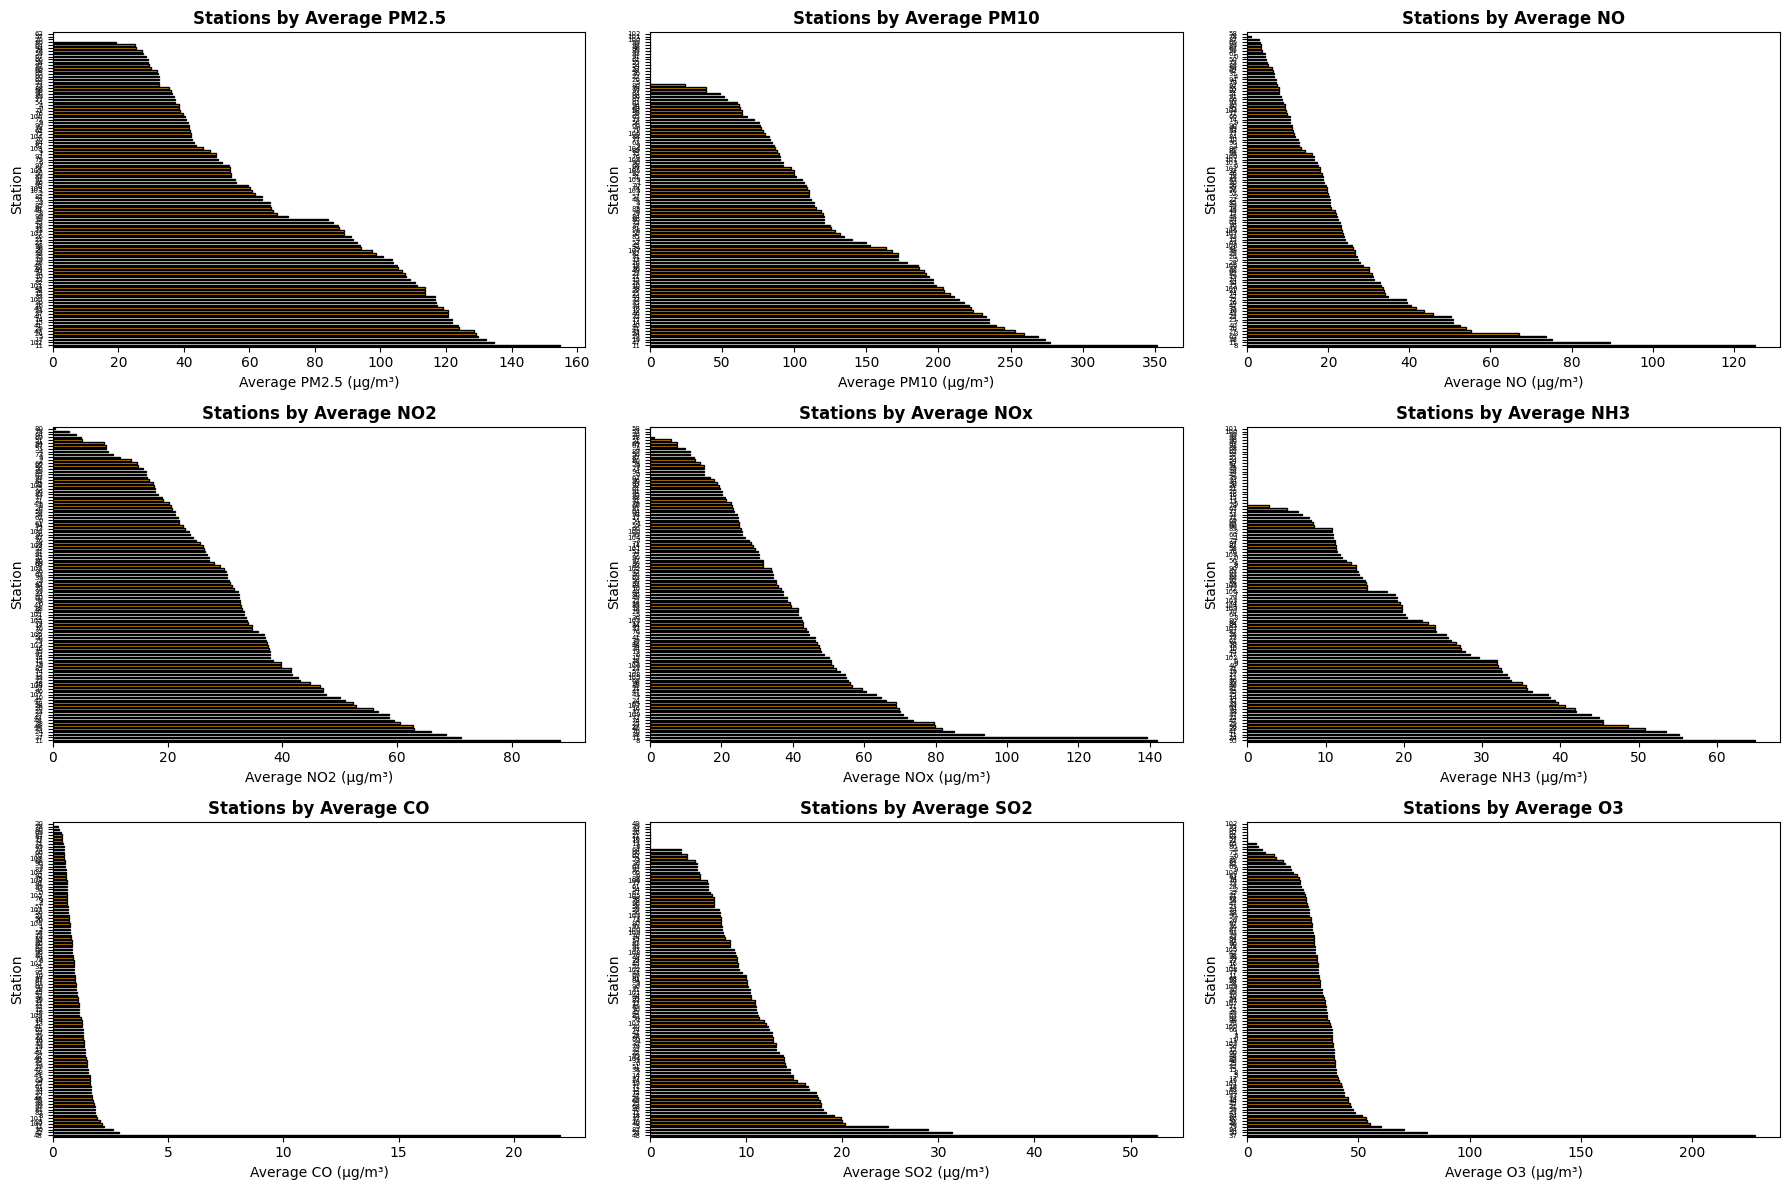

In [58]:
def avg_pollutant_by_station(df):

    # pollutant list
    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    stations_mean = (
        df.groupby('StationId')[pollutants]
          .mean()
          .reset_index()
    )

    # Stations by average pollutant levels

    # Create subplots: 3 rows × 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()  # make axes 1D for easy looping

    # Plot each pollutant
    for i, pollutant in enumerate(pollutants):
        # Sort stations for that pollutant
        sorted_data = stations_mean[pollutant].sort_values(ascending=False)

        sorted_data.plot(
            kind='barh',
            ax=axes[i],
            color='orange',
            edgecolor='black'
        )
        axes[i].set_title(f'Stations by Average {pollutant}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(f'Average {pollutant} (µg/m³)', fontsize=10)
        axes[i].set_ylabel('Station', fontsize=10)
        axes[i].tick_params(axis='y', labelsize=5)


    plt.tight_layout()
    plt.show()

avg_pollutant_by_station(df)

Nan value analysis.

Missing Percentage by Pollutant (%): NH3      47.762779
PM10     43.229669
SO2      28.687261
O3       28.039773
PM2.5    25.016154
AQI      22.022855
NO       21.386375
NO2      20.430902
CO       19.284897
NOx      18.956828
dtype: float64


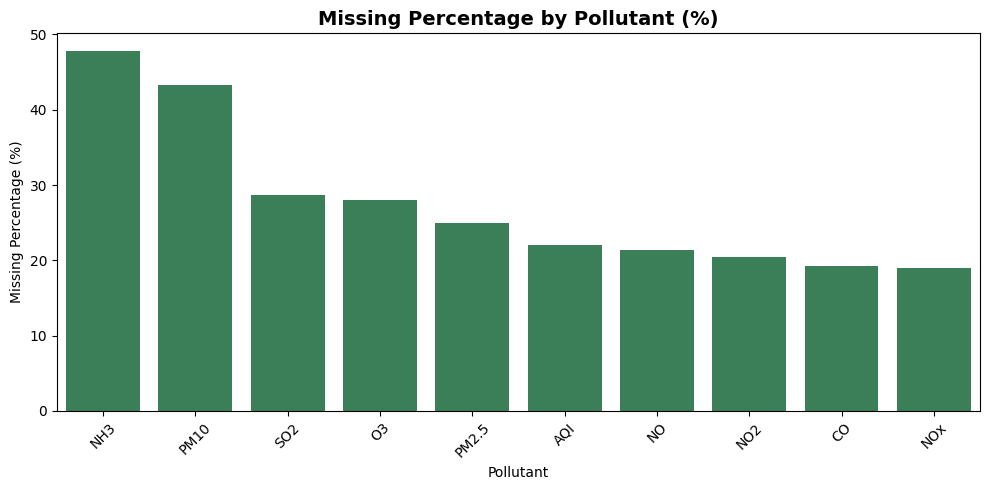

Top 10 Cities with Highest Missing Rates (%):
City
Jorapokhar      48.284746
Ahmedabad       46.816484
Chennai         37.758513
Bengaluru       36.306005
Gurugram        36.250221
Lucknow         34.655496
Patna           34.620731
Talcher         30.305492
Mumbai          29.625427
Brajrajnagar    29.408492
dtype: float64


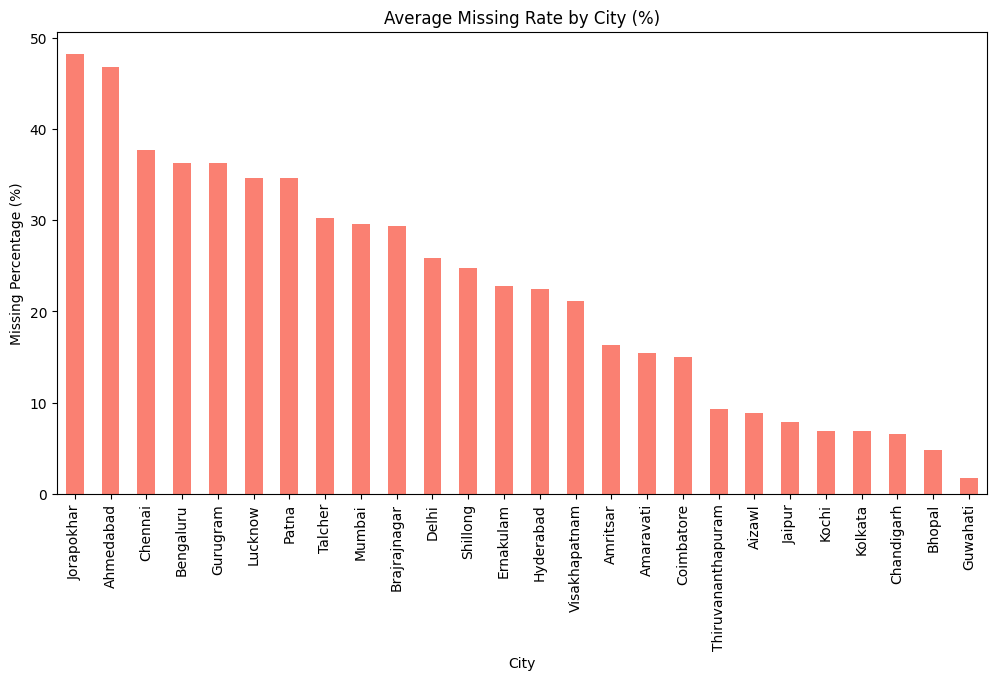

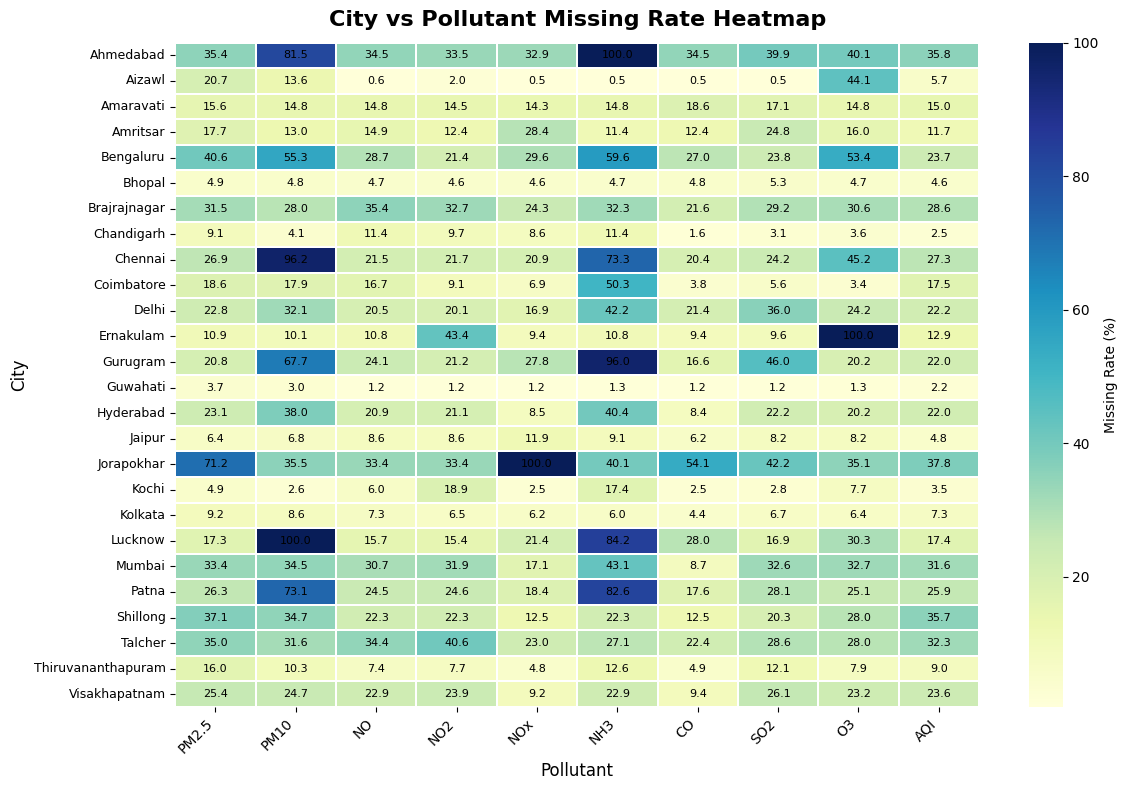

Top 10 Monitoring Stations with Highest Missing Rates:
                                              PM2.5        PM10         NO  \
StationName                                                                  
East Arjun Nagar, Delhi - CPCB           100.000000  100.000000  62.444946   
Bandra, Mumbai - MPCB                     67.193725   69.407786  67.075448   
City Railway Station, Bengaluru - KSPCB  100.000000   34.349718  33.555463   
CRRI Mathura Road, Delhi - IMD            42.496680   42.229001  43.312168   
DTU, Delhi - CPCB                         53.981989   61.012201  49.923224   
Sanegurava Halli, Bengaluru - KSPCB      100.000000   39.473684  37.860860   
IHBAS, Dilshad Garden, Delhi - CPCB       40.033616  100.000000  39.614459   
Shadipur, Delhi - CPCB                    49.109811  100.000000  23.887782   
Tata Stadium, Jorapokhar - JSPCB          71.190009   35.504014  33.423729   
ITO, Delhi - CPCB                         55.269282   46.018949  43.405086   

        

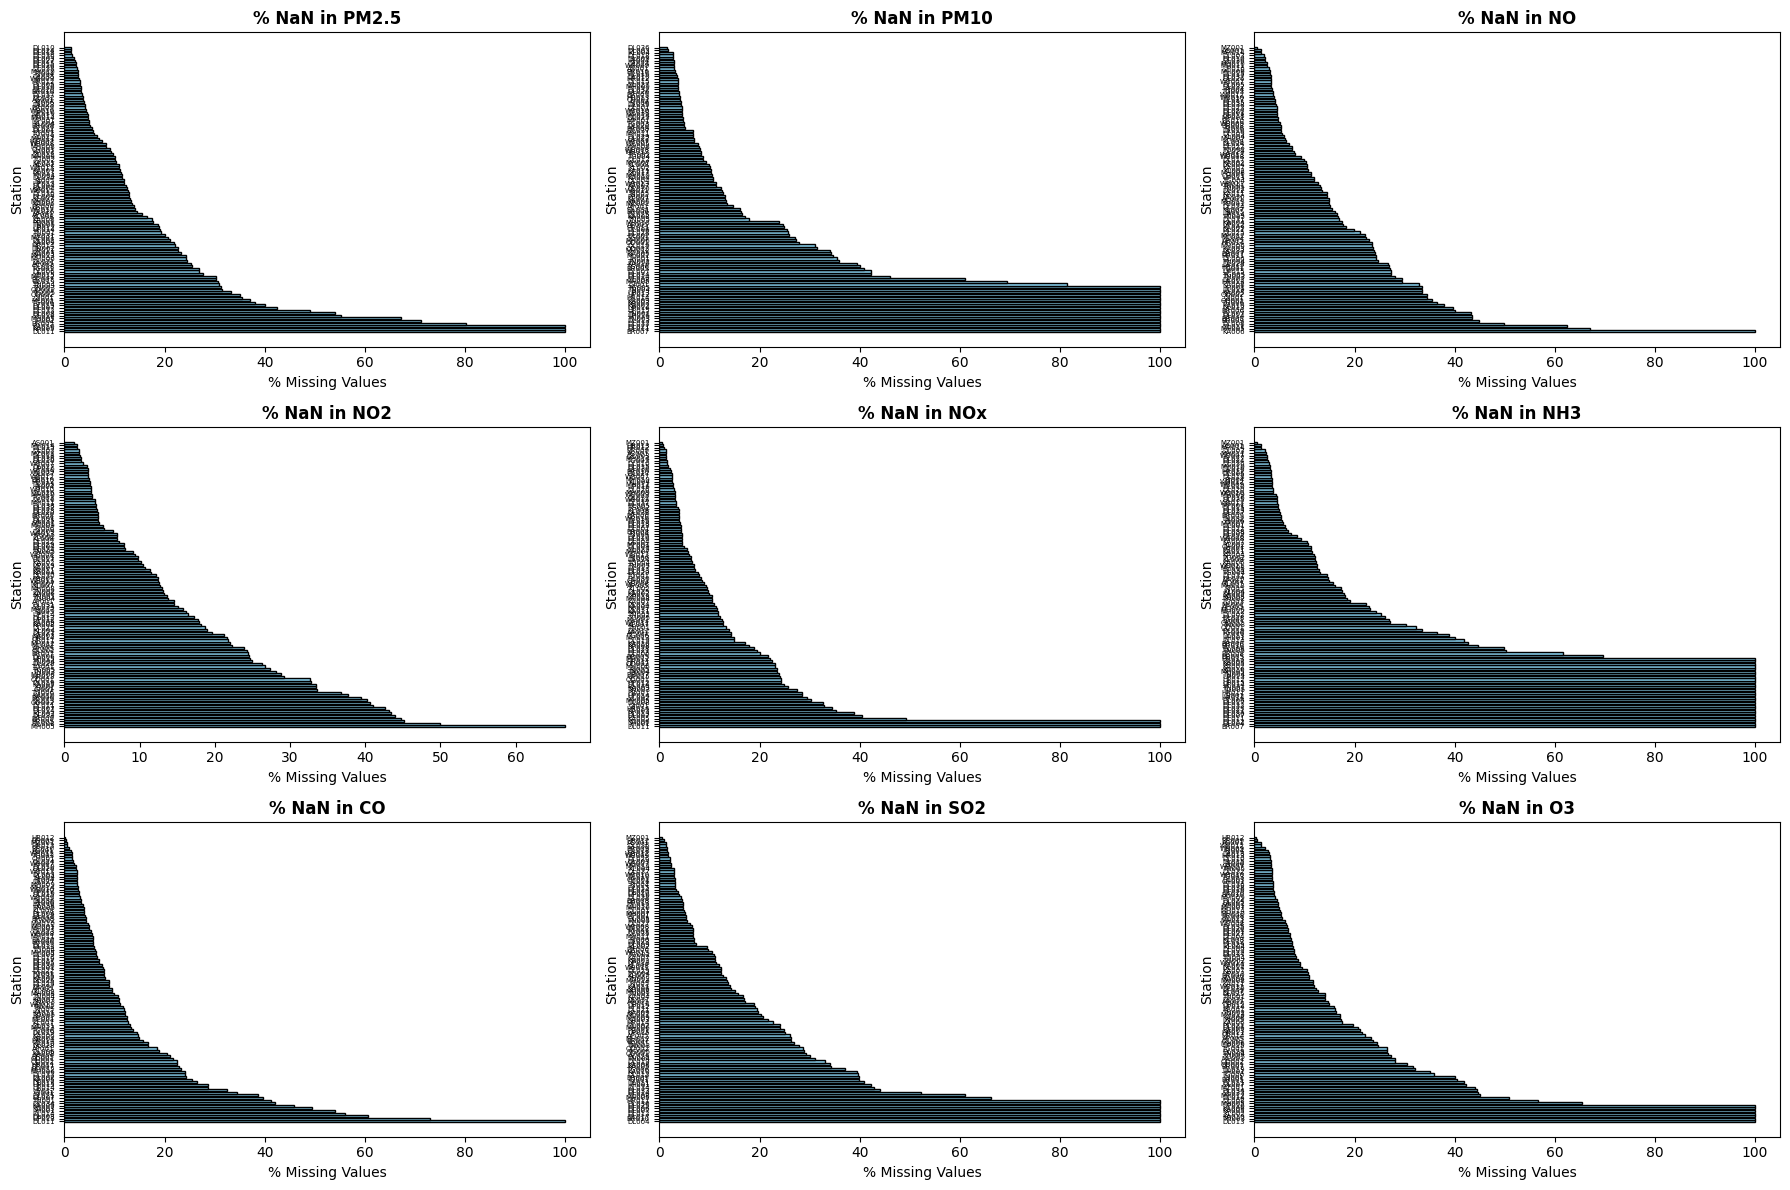

In [59]:
def nan_by_pollutant(df):

    India = df.copy()

    # Keep only pollutant-related columns
    polls = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']


    miss_pct = {}
    for c in polls:
        total_valid = India[c].notna().sum() + India[c].isna().sum()  
        miss_pct[c] = (India[c].isna().sum() / total_valid) * 100

    miss_pct = pd.Series(miss_pct).sort_values(ascending=False)
    print("Missing Percentage by Pollutant (%):", miss_pct)

    plt.figure(figsize=(10,5))
    sns.barplot(x=miss_pct.index, y=miss_pct.values, color='seagreen')
    plt.title("Missing Percentage by Pollutant (%)", fontsize=14, fontweight='bold')
    plt.ylabel("Missing Percentage (%)")
    plt.xlabel("Pollutant")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def nan_by_city(df):

    India = df.copy()
    #--------------------------------------------------------------------------------------------------------------------------------
    # Calculate missing rate by city
    # Keep only pollutant-related columns
    polls = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']
    
    city_miss = India.groupby('City')[polls].apply(lambda x: x.isnull().mean() * 100)
    city_miss_mean = city_miss.mean(axis=1).sort_values(ascending=False)

    print("Top 10 Cities with Highest Missing Rates (%):")
    print(city_miss_mean.head(10))

    plt.figure(figsize=(12,6))
    city_miss_mean.plot(kind='bar', color='salmon')
    plt.title("Average Missing Rate by City (%)")
    plt.ylabel("Missing Percentage (%)")
    plt.xlabel("City")
    plt.show()

    plt.figure(figsize=(12,8))
    sns.heatmap(
        city_miss,
        cmap='YlGnBu',       
        linewidths=0.3,       
        linecolor='white',
        cbar_kws={'label': 'Missing Rate (%)'},
        annot=True,             
        fmt=".1f",            
        annot_kws={'size':8, 'color':'black'} 
    )

    plt.title("City vs Pollutant Missing Rate Heatmap", fontsize=16, fontweight='bold', pad=12)
    plt.xlabel("Pollutant", fontsize=12)
    plt.ylabel("City", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()

def nan_by_station(df):

    India = df.copy()
    #  Calculate missing rate by monitoring station

    polls = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']

    station_miss = India.groupby('StationName')[polls].apply(lambda x: x.isnull().mean() * 100)
    station_miss['Average'] = station_miss.mean(axis=1)
    station_miss = station_miss.sort_values('Average', ascending=False)

    print("Top 10 Monitoring Stations with Highest Missing Rates:")
    print(station_miss.head(10))

def nan_percent_by_station(df):

    # pollutant list
    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    # Calculate % of NaN values for each pollutant per station
    stations_nan_pct = (
        df.groupby('StationId')[pollutants]
          .apply(lambda x: x.isna().mean() * 100)
          .reset_index()
    )

    # Create subplots: 3 rows × 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()  # make axes 1D for easy looping

    # Plot each pollutant
    for i, pollutant in enumerate(pollutants):
        # Sort stations by % NaN for that pollutant
        sorted_data = stations_nan_pct.sort_values(by=pollutant, ascending=False)

        axes[i].barh(sorted_data['StationId'], sorted_data[pollutant],
                     color='skyblue', edgecolor='black')

        axes[i].set_title(f'% NaN in {pollutant}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('% Missing Values', fontsize=10)
        axes[i].set_ylabel('Station', fontsize=10)
        axes[i].tick_params(axis='y', labelsize=5)

    plt.tight_layout()
    plt.show()

nan_by_pollutant(df)
nan_by_city(df)
nan_by_station(df)
nan_percent_by_station(df)

Outliers.

imputing for nan values

In [ ]:
def knn_impute_selected_stations(df, threshold=30, n_neighbors=3):
    """
    Perform KNN imputation only for stations with < threshold% missing data.

    Parameters:
        df : pd.DataFrame
            Must contain 'StationName' and pollutant columns.
        threshold : float
            Maximum allowed % of missing values to apply KNN imputation.
        n_neighbors : int
            Number of neighbors for KNN imputer.

    Returns:
        pd.DataFrame : Imputed dataframe.
    """

    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']
    df = df.copy()

    # Compute % of missing values per station across all pollutants
    missing_pct = (
        df.groupby('StationName')[pollutants]
          .apply(lambda x: x.isna().mean().mean() * 100)
    )

    # Select stations with < threshold % missing
    good_stations = missing_pct[missing_pct < threshold].index
    bad_stations = missing_pct[missing_pct >= threshold].index

    print(f"Stations eligible for KNN imputation (<{threshold}% missing): {len(good_stations)}")
    print(f"Stations excluded: {len(bad_stations)}")

    # Initialize KNN imputer
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Separate data
    df_good = df[df['StationName'].isin(good_stations)].copy()
    df_bad = df[df['StationName'].isin(bad_stations)].copy()

    # Apply KNN imputation to good stations only
    df_good[pollutants] = imputer.fit_transform(df_good[pollutants])

    # Combine back
    df_imputed = pd.concat([df_good, df_bad], ignore_index=True)

    return df_imputed


## Modelling

data set prep and splitting

Station id as feature.

In [52]:
# Remove rows where target variable (O3) is missing
df_clean = df.dropna(subset=['O3'])
# Remove Punjabi Bagh station due to extreme outlier O3 data
df_clean = df_clean[df_clean['StationName'] != 'Punjabi Bagh, Delhi - DPCC']

df_clean['stationid_int'], uniques = pd.factorize(df_clean['StationId'])


# Prepare features and target - EXCLUDE O3 from features since it's our target
feature_columns = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'hour', 'month','day', 'year', 'stationid_int']


#-------------------------------------------------------------------------------------------
# dataset for final training

X = df_clean[feature_columns]  # Can contain NaN values
y = df_clean['O3']  # Should not contain NaN

# ------------------------------------------------------------------------------------------
# Normalised dataset 
col_to_norm = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2']
X_norm = X.copy()
# Scale only selected columns
scaler = preprocessing.StandardScaler()
X_norm[col_to_norm] = scaler.fit_transform(X[col_to_norm])

# Split into train-test FIRST
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

#--------------------------------------------------------------------------------------------
# subset for testing

# Get n random stations
subset_stations = np.random.choice(df_clean['StationId'].unique(), size=10, replace=False)

# Filter
subset_df = df_clean[df_clean['StationId'].isin(subset_stations)]

print("Randomly selected stations:", subset_stations)

X_sub  = subset_df[feature_columns] 
y_sub = subset_df['O3']

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)

Randomly selected stations: ['DL024' 'KA004' 'DL009' 'DL033' 'WB007' 'DL019' 'DL030' 'DL007' 'WB012'
 'DL029']


imputing nan values

Test different imputing methods

- median 
- knn 
- moving average 

test how they perform in filling in data in comparsion to pre existing data

get r squared score for different imputing methods for random forest and hist xgboost and produce a bar chart showing accuracy of different imputing mathiods and just with nan values

only use station day data for now 

dont worry about optimision of the models as this will be done seperatly just use basic model and see how they are impacted by the imputing of data

random forest

            State       City StationId  hour  dayofweek    SO2  \
0  Andhra Pradesh  Amaravati     AP001    17          4  11.85   
1  Andhra Pradesh  Amaravati     AP001    18          4  13.17   
2  Andhra Pradesh  Amaravati     AP001    19          4  12.08   
3  Andhra Pradesh  Amaravati     AP001    20          4  10.47   
4  Andhra Pradesh  Amaravati     AP001    21          4   9.12   

             datetime    NH3  PM2.5    NO2  ...    PM10    NOx        lon  \
0 2017-11-24 17:00:00   8.50  60.50  30.80  ...   98.00  18.25  80.510586   
1 2017-11-24 18:00:00   9.77  65.50  24.20  ...  111.25  15.07  80.510586   
2 2017-11-24 19:00:00  12.02  80.00  25.18  ...  132.00  15.15  80.510586   
3 2017-11-24 20:00:00  11.58  81.50  16.25  ...  133.25  10.23  80.510586   
4 2017-11-24 21:00:00  12.03  75.25  17.48  ...  116.00  10.43  80.510586   

   year      O3  day  AQI  AQI_Bucket        lat    NO  
0  2017  126.40   24  NaN         NaN  16.494222  2.35  
1  2017  117.12   24  NaN 

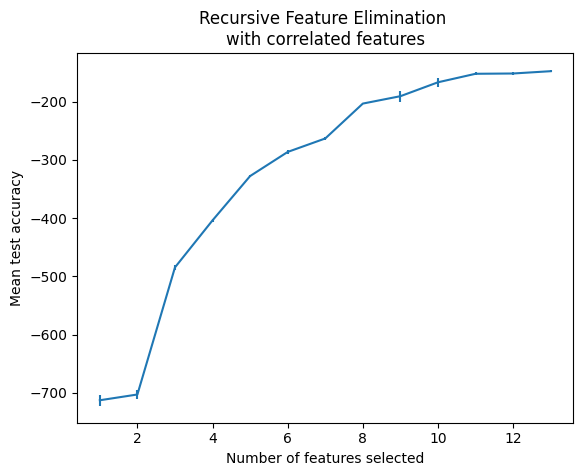

In [ ]:
def recursive_feature_elimination_forest(X_train, y_train):

    min_features_to_select = 1  # Minimum number of features to consider
    clf = RandomForestRegressor(
            n_estimators=100,
    )

    rfecv = RFECV(
        estimator=clf,
        step=1,
        scoring='neg_mean_squared_error',
        min_features_to_select=min_features_to_select,
        n_jobs=2,
        verbose = 1
    )
    rfecv.fit(X_train, y_train)

    feature_names = X_train.columns  # assuming X_train is a DataFrame
    selected_features = feature_names[rfecv.support_]
    ranked_features = pd.DataFrame({
        "Feature": feature_names,
        "Rank": rfecv.ranking_
    }).sort_values("Rank")

    print("\nSelected Features:")
    print(selected_features.tolist())

    print("\nFeature Ranking:")
    print(ranked_features)


    print(f"Optimal number of features: {rfecv.n_features_}")
    
    data = {
        key: value
        for key, value in rfecv.cv_results_.items()
        if key in ["n_features", "mean_test_score", "std_test_score"]
    }
    cv_results = pd.DataFrame(data)
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.errorbar(
        x=cv_results["n_features"],
        y=cv_results["mean_test_score"],
        yerr=cv_results["std_test_score"],
    )
    plt.title("Recursive Feature Elimination \nwith correlated features")
    plt.show()

    return selected_features, ranked_features

print(subset_df.head())
selected, ranked = recursive_feature_elimination_forest(X_train_sub, y_train_sub)

| Feature   | Rank |
|------------|------|
| PM2.5      | 1    |
| PM10       | 2    |
| NO         | 3    |
| NO2        | 4    |
| NOx        | 5    |
| NH3        | 6    |
| CO         | 7    |
| SO2        | 8    |
| hour       | 9    |
| month      | 10   |
| dayofweek  | 11   |
| day        | 12   |
| lat        | 13   |
| lon        | 14   |

Only features of to month imporved model, after this the perfromace plateaued



In [14]:
def random_forest_grid_search(X_train, X_test, y_train, y_test):

    param_grid = {
    'max_features': [0.6, 0.8, 1, 'sqrt', 'log2'],
    'max_samples': [0.6, 0.8, 1],
    'max_depth': [10, 20, None]

    }

    grid = HalvingGridSearchCV(
        estimator=RandomForestRegressor(n_estimators=100, random_state=1),
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        return_train_score=True,
        verbose =2,
        aggressive_elimination = True
    )

    grid.fit(X_train, y_train)

    print("Best Parameters:", grid.best_params_)
    print("Best Score:", -grid.best_score_)

    return grid.best_params_


best_params = random_forest_grid_search(X_train_sub, X_test_sub, y_train_sub, y_test_sub)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 4941
max_resources_: 133430
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 45
n_resources: 4941
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 1
n_candidates: 15
n_resources: 14823
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 2
n_candidates: 5
n_resources: 44469
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 3
n_candidates: 2
n_resources: 133407
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'max_depth': None, 'max_features': 0.8, 'max_samples': 0.8}
Best Score: 146.84204774571745


In [16]:
def random_forest(X_train, X_test, y_train, y_test, best_params = None, feature_columns = None):


    if feature_columns is not None:
        X_train = X_train[feature_columns]
        X_test = X_test[feature_columns]

    # Then create and fit model ONLY on training data
    if best_params:
        regr = RandomForestRegressor(
            n_estimators=100,
            max_features=best_params['max_features'],
            max_samples=best_params['max_samples'],
            max_depth=best_params['max_depth']
        )
    else:
        regr = RandomForestRegressor(
            n_estimators=100,
            max_features=0.8,
        )

    regr.fit(X_train, y_train)

    # Predictions
    y_train_pred = regr.predict(X_train)
    y_test_pred = regr.predict(X_test)

    # Evaluation
    def evaluate(y_true, y_pred, dataset_type="Test"):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        print(f"{dataset_type} MAE: {mae:.2f}")
        print(f"{dataset_type} MSE: {mse:.2f}")
        print(f"{dataset_type} RMSE: {rmse:.2f}")
        print(f"{dataset_type} R²: {r2:.2f}")

    evaluate(y_train, y_train_pred, "Train")
    evaluate(y_test, y_test_pred, "Test")

    def plotting():

        # Feature Importance
        importances = regr.feature_importances_
        feature_names = X_train.columns
        feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        # plot feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importances, y=feature_importances.index)
        plt.title('Feature Importances from Random Forest')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()

        # Residual Analysis
        residuals = y_test - y_test_pred
        plt.figure(figsize=(10, 5))
        sns.histplot(residuals, kde=True)
        plt.title('Residual Distribution')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

        # plotting tree
        tree_to_plot = regr.estimators_[0]

        plt.figure(figsize=(20, 10))
        plot_tree(tree_to_plot, max_depth = 3, feature_names=df.columns.tolist(), filled=True, rounded=True, fontsize=10)
        plt.title("Decision Tree from Random Forest")
        plt.show()

    plotting()

    return regr

In [ ]:
# selected from rfe from 2019 dataset at frac = 0.1
selected = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'hour', 'month',  'year', 'stationid_int']
features = selected
model = random_forest(X_train, X_test, y_train, y_test, feature_columns=features)

xgboost

custom recursive feature elimination from chat as ist boost regressor not compatible with rfecv

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting 

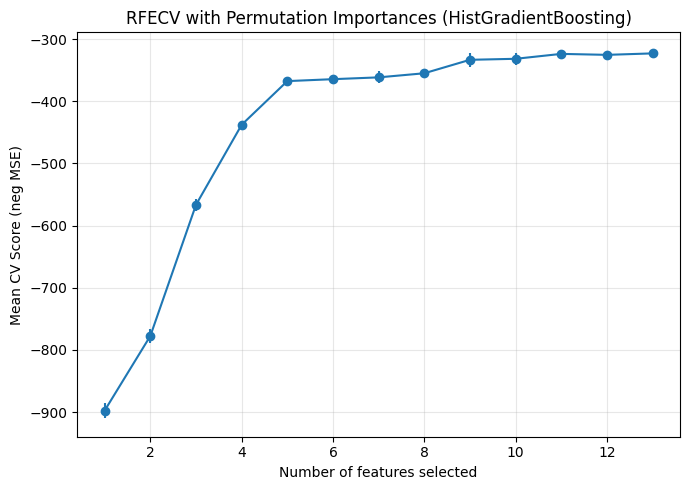

In [32]:
from sklearn.base import BaseEstimator, RegressorMixin, clone


# --- 1️⃣ Custom wrapper around HistGradientBoostingRegressor ---
class PermutationImportanceHGBR(BaseEstimator, RegressorMixin):
    def __init__(self, random_state=42, n_repeats=5):
        self.random_state = random_state
        self.n_repeats = n_repeats
        self.model = HistGradientBoostingRegressor(
            random_state=self.random_state
        )

    def fit(self, X, y):
        self.model.fit(X, y)
        # Compute permutation importance on training data
        result = permutation_importance(
            self.model, X, y,
            n_repeats=self.n_repeats,
            random_state=self.random_state,
            scoring='neg_mean_squared_error'
        )
        # Store feature_importances_ so RFECV can use it
        self.feature_importances_ = np.abs(result.importances_mean)
        return self

    def predict(self, X):
        return self.model.predict(X)


# --- 2️⃣ The RFECV function ---
def recursive_feature_elimination_xg(X_train, y_train):
    """
    Perform Recursive Feature Elimination with Cross-Validation (RFECV)
    using HistGradientBoostingRegressor + permutation-based importances.
    """

    # Use our wrapped model
    clf = PermutationImportanceHGBR(
        random_state=42,
        n_repeats=1
    )

    # RFECV setup
    rfecv = RFECV(
        estimator=clf,
        step=1,
        scoring='neg_mean_squared_error',
        min_features_to_select=1,
        cv=KFold(5, shuffle=True, random_state=42),
        n_jobs=1,
        verbose=1
    )

    # Fit
    rfecv.fit(X_train, y_train)

    # Extract selected & ranked features
    feature_names = X_train.columns
    feature_importances = rfecv.estimator_.feature_importances_
    ranked_features = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances,
        "Rank": rfecv.ranking_
    }).sort_values("Importance", ascending=False).reset_index(drop=True)

    selected_features = ranked_features.loc[ranked_features["Rank"] == 1, "Feature"]
    
    print("\n✅ Selected Features:")
    print(selected_features.tolist())

    print("\n🏅 Feature Ranking:")
    print(ranked_features)

    print(f"\n⭐ Optimal number of features: {rfecv.n_features_}")

    # --- Plot CV results using modern sklearn ---
    cv_results = pd.DataFrame({
        "n_features": rfecv.cv_results_["n_features"],
        "mean_test_score": rfecv.cv_results_["mean_test_score"],
        "std_test_score": rfecv.cv_results_["std_test_score"]
    })

    plt.figure(figsize=(7, 5))
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean CV Score (neg MSE)")
    plt.errorbar(
        x=cv_results["n_features"],
        y=cv_results["mean_test_score"],
        yerr=cv_results["std_test_score"],
        fmt='-o'
    )
    plt.title("RFECV with Permutation Importances (HistGradientBoosting)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return selected_features, ranked_features


# --- 3️⃣ Example usage ---
selected, ranked = recursive_feature_elimination_xg(X_train_sub, y_train_sub)


In [34]:
print(selected, ranked)
# top 5 features
hxb_important = ranked['Feature'].head(9).tolist()
print(hxb_important)

0              hour
1             month
2     stationid_int
3                NO
4              year
5               NH3
6              PM10
7               NOx
8               NO2
9               SO2
10              day
11            PM2.5
12               CO
Name: Feature, dtype: object           Feature  Importance  Rank
0            hour  546.779012     1
1           month  366.919297     1
2   stationid_int  270.002671     1
3              NO  207.437740     1
4            year  144.195754     1
5             NH3  102.279850     1
6            PM10   75.051548     1
7             NOx   57.450376     1
8             NO2   54.974064     1
9             SO2   48.199852     1
10            day   38.295538     1
11          PM2.5   21.765423     1
12             CO   19.886831     1
['hour', 'month', 'stationid_int', 'NO', 'year', 'NH3', 'PM10', 'NOx', 'NO2']


Plateu of performance after 9 features.

Binning 0.137 GB of training data: 1.842 s
Binning 0.015 GB of validation data: 0.120 s
Fitting gradient boosted rounds:
Fit 10000 trees in 1289.590 s, (310000 total leaves)
Time spent computing histograms: 549.668s
Time spent finding best splits:  52.254s
Time spent applying splits:      185.282s
Time spent predicting:           64.265s
R²: 0.811
RMSE: 14.235
MAE: 9.070


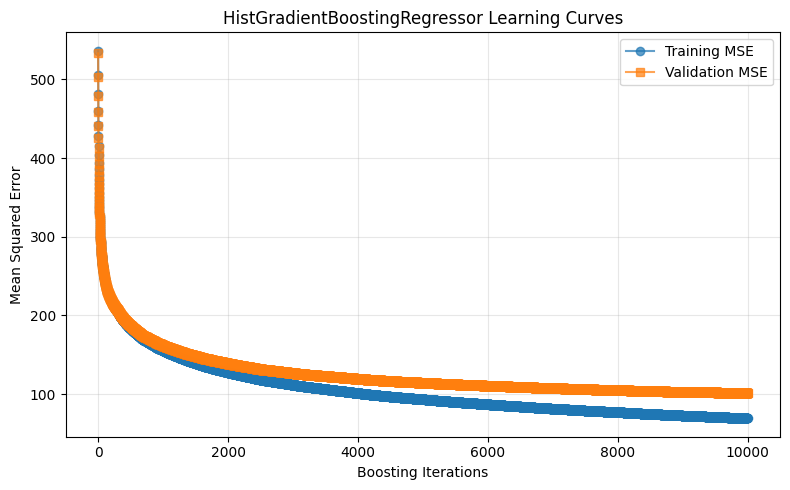

In [53]:
def hxg_boost(X_train, X_test, y_train, y_test, selected_features = None):

    if selected_features is not None:
        X_train = X_train[selected_features]
        X_test = X_test[selected_features]

    # Then create and fit model ONLY on training data
    model = HistGradientBoostingRegressor(
        random_state=42,
        early_stopping = True,
        n_iter_no_change = 10,
        max_iter = 10000,
        verbose = 1,
        warm_start= True
    )

    # Fit directly with NaN values
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f'R²: {r2:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'MAE: {mae:.3f}')

    
    # --- 4️⃣ Extract training and validation scores ---
    train_scores = -np.array(model.train_score_)  # convert from neg MSE to positive MSE
    val_scores = -np.array(model.validation_score_) if model.validation_score_ is not None else None

    # --- 5️⃣ Plot learning curves ---
    plt.figure(figsize=(8, 5))
    plt.plot(train_scores, label="Training MSE", marker='o', alpha=0.7)
    if val_scores is not None:
        plt.plot(val_scores, label="Validation MSE", marker='s', alpha=0.7)
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Mean Squared Error")
    plt.title("HistGradientBoostingRegressor Learning Curves")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Cross-validation - create fresh model for CV
    #cv_model = HistGradientBoostingRegressor(random_state=42, max_iter=100)
    #cv_scores = cross_val_score(cv_model, X, y, cv=5, scoring='r2')
    #print(f'Cross-Validation Mean R²: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}')

    # Use permutation importance
    from sklearn.inspection import permutation_importance

    def plotting():
        # Calculate permutation importance on test set
        perm_importance = permutation_importance(model, X_test, y_test, random_state=42, n_repeats=10)
        importances = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False)

        print("\nPermutation Feature Importances:")
        print(importances)

        plt.figure(figsize=(10,6))
        sns.barplot(x=importances.values, y=importances.index)
        plt.title('Permutation Feature Importance for O₃ Prediction')
        plt.xlabel('Importance Score (Decrease in R² when shuffled)')
        plt.ylabel('Feature')
        plt.show()

        plt.figure(figsize=(8,6))
        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.xlabel("Actual O₃")
        plt.ylabel("Predicted O₃")
        plt.title("Actual vs Predicted O₃ Levels")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect fit line
        plt.show()

        # Residual plot
        residuals = y_test - y_pred
        plt.figure(figsize=(8,6))
        sns.histplot(residuals, kde=True)
        plt.title('Residual Distribution')
        plt.show()

    # return results or model

hxg_boost(X_train, X_test, y_train, y_test)

svm

knn

Neural Net/ lstm 

Voting regressor

### comparing results

Time to train vs r squared score plot

Change dataset size.

change amount of features used.

bar graph of accuracies for with and without imputation of Nan values